In [1]:
from splender.image2 import SplenderImage
import jax.random as random
from jax import vmap, value_and_grad, grad, jit
from interpax import Interpolator1D
from functools import partial

import numpy as np
import jax
import jax.numpy as jnp
from minimum_spanning_tree_inverse_spline_render import get_splines_from_frame

import matplotlib.pyplot as plt

import jax.tree_util as jtu

import optax


In [2]:
dat = np.loadtxt('mnist_train.csv', delimiter=',')

In [3]:
def fit_spline(knots):
    x, y = knots[..., 0], knots[..., 1]
    
    s = jnp.linspace(0, 1, len(x))
    x_spline = Interpolator1D(s, x, method="cubic2")
    y_spline = Interpolator1D(s, y, method="cubic2")
    return x_spline, y_spline

def get_uniform_points(x_spline, y_spline, n_points_per_spline = 8):
    eps = 1e-6
    # Compute arc length
    dx_ds = vmap(partial(x_spline, dx=1))
    dy_ds = vmap(partial(y_spline, dx=1))
    s_fine = jnp.linspace(0, 1, n_points_per_spline)
    ds_vals = jnp.sqrt(dx_ds(s_fine)**2 + dy_ds(s_fine)**2 + eps)
    delta_s = s_fine[1] - s_fine[0]
    cumulative_length = jnp.concatenate([
        jnp.array([0.0]),
        jnp.cumsum(0.5 * (ds_vals[1:] + ds_vals[:-1]) * delta_s)
    ])
    s_uniform = jnp.interp(jnp.linspace(0, cumulative_length[-1], n_points_per_spline), cumulative_length, s_fine)
    return s_uniform, cumulative_length[-1]

def downsample_points(coords):
    x_spline, y_spline = fit_spline(coords)
    s_uniform, length = get_uniform_points(x_spline, y_spline, n_points_per_spline=8)
    x = x_spline(s_uniform)
    y = y_spline(s_uniform)
    return jnp.stack([x, y], axis=-1)

31
(8, 2)


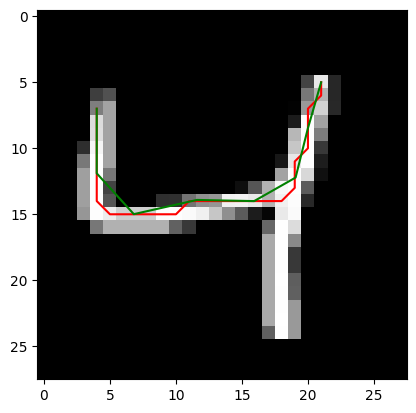

18
(8, 2)


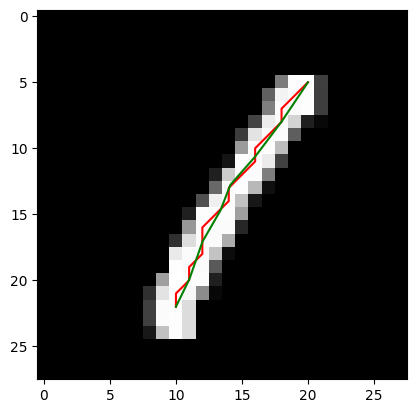

In [4]:
i = 2
images = []
init_splines = []
for i in [2, 3]:
    img = dat[i, 1:].reshape(28, 28)
    img = img / 255.0
    images.append(img)
    path = get_splines_from_frame(img, 0.1)[0][:, ::-1]
    print(len(path))
    init_spline = np.array(path).astype(np.float32)
    init_spline = downsample_points(init_spline)
    init_splines.append(init_spline[None])
    print(init_spline.shape)
    plt.imshow(img, cmap='gray')
    plt.plot(path[:, 0], path[:, 1], 'r-')
    plt.plot(init_spline[:, 0], init_spline[:, 1], 'g-')
    plt.show()

In [5]:
images = jnp.array(images)

In [6]:
init_splines = jnp.array(init_splines) / 28

In [7]:
# model = SplenderImage(random.PRNGKey(0), init_splines, res = 28)
model = SplenderImage()

In [8]:
model = model.init(random.PRNGKey(0), init_knots=init_splines, res=28)

In [9]:
model.res

28

In [10]:
model.loc_params

Array([[[[-0.2523591 , -0.48587483,  5.        ]]],


       [[[ 0.05236834, -0.04692993,  5.        ]]]], dtype=float32)

In [11]:
ims, lengths, curvatures = model()

In [12]:
ims

Array([[[0.5, 0.5, 0.5, ..., 0.5, 0.5, 0.5],
        [0.5, 0.5, 0.5, ..., 0.5, 0.5, 0.5],
        [0.5, 0.5, 0.5, ..., 0.5, 0.5, 0.5],
        ...,
        [0.5, 0.5, 0.5, ..., 0.5, 0.5, 0.5],
        [0.5, 0.5, 0.5, ..., 0.5, 0.5, 0.5],
        [0.5, 0.5, 0.5, ..., 0.5, 0.5, 0.5]],

       [[0.5, 0.5, 0.5, ..., 0.5, 0.5, 0.5],
        [0.5, 0.5, 0.5, ..., 0.5, 0.5, 0.5],
        [0.5, 0.5, 0.5, ..., 0.5, 0.5, 0.5],
        ...,
        [0.5, 0.5, 0.5, ..., 0.5, 0.5, 0.5],
        [0.5, 0.5, 0.5, ..., 0.5, 0.5, 0.5],
        [0.5, 0.5, 0.5, ..., 0.5, 0.5, 0.5]]], dtype=float32)

In [13]:
model.loc_params

Array([[[[-0.2523591 , -0.48587483,  5.        ]]],


       [[[ 0.05236834, -0.04692993,  5.        ]]]], dtype=float32)

In [14]:
model

SplenderImage(brush_profile=Array([1.        , 0.69444454, 0.4444444 , 0.25      , 0.11111107,
       0.02777776, 0.        , 0.0277778 , 0.11111113, 0.25      ,
       0.44444454, 0.69444454, 1.        ], dtype=float32), spline_contrast=Array([1.], dtype=float32), spline_brightness=Array([0.], dtype=float32), loc_params=Array([[[[-0.2523591 , -0.48587483,  5.        ]]],


       [[[ 0.05236834, -0.04692993,  5.        ]]]], dtype=float32), knot_params=Array([[[[ 1.3509717 , -1.0401814 ,  0.        ],
         [ 1.1681991 , -0.34738296,  0.        ],
         [ 1.0100061 ,  0.23005375,  0.        ],
         [ 0.5287676 ,  0.48620737,  0.        ],
         [-0.09535694,  0.47344255,  0.        ],
         [-0.8828923 ,  0.6275515 ,  0.        ],
         [-1.5402946 ,  0.18304649,  0.        ],
         [-1.5394003 , -0.61273736,  0.        ]]],


       [[[-0.64015496,  1.3462132 ,  0.        ],
         [-0.48379973,  0.9445306 ,  0.        ],
         [-0.3375813 ,  0.49053094,  0

In [15]:
@jit
def loss(model, images):
    recon, lengths, curvatures = model()
    recon_loss = jnp.mean((images - recon) ** 2)
    min_scale_knots = jax.nn.sigmoid((model.loc_params + model.knot_params)[..., 2]).min(axis = -1)
    # jax.debug.print("min_scale_knots: {min_scale_knots}", min_scale_knots=min_scale_knots)
    scale_multiplier_reg = 1e-3 * ((min_scale_knots - 1.0)**2).mean()
    return recon_loss + scale_multiplier_reg

def make_step(model, images, opt_state):
    # loss_value, grads = value_and_grad(loss)(model, images)
    grads = grad(loss)(model, images)
    # jax.debug.print("loss: {loss_value}", loss_value=loss_value)
    # jax.debug.print("grads: {grads}", grads=grads)
    updates, opt_state = optim.update(grads, opt_state, model)
    model = optax.apply_updates(model, updates)
    return model, opt_state

In [16]:
model.loc_params

Array([[[[-0.2523591 , -0.48587483,  5.        ]]],


       [[[ 0.05236834, -0.04692993,  5.        ]]]], dtype=float32)

In [17]:
optim = optax.adam(1e-2)
losses = []
opt_state = optim.init(model)
for step in range(1000):
    model, opt_state = make_step(model, images, opt_state)

In [18]:
optim = optax.adam(1e-4)
opt_state = optim.init(model)
for step in range(1):
    model_s, opt_state = make_step(model, images, opt_state)
    # model_s, opt_state, loss_value = make_step(model, images, opt_state, filter_splines)
    # losses.append(loss_value)

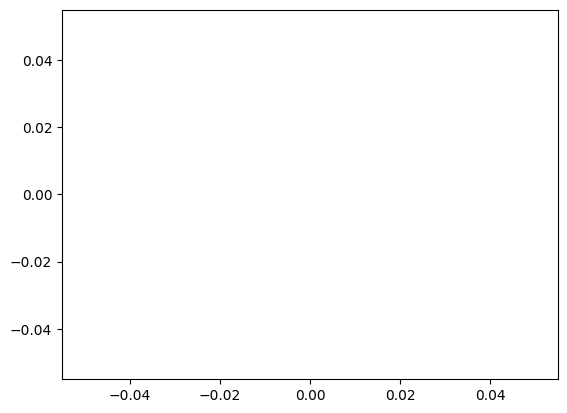

In [19]:
plt.plot(losses)
# plt.ylim(0.0665, 0.0668)

In [20]:
ims, lengths, curvatures = model()

In [21]:
print("model.loc_params", model.loc_params)
print("model.knot_params", model.knot_params)
print("model.global_scale", model.global_scale)
print("model.brush_profile", model.brush_profile)
print("model.kernel", model.kernel)
print("model.opacity", model.opacity)

model.loc_params [[[[-0.26353064 -0.21184497  1.9402453 ]]]


 [[[ 0.06209932 -0.01914327  3.0373247 ]]]]
model.knot_params [[[[ 1.4167409  -1.3323189  -0.49587774]
   [ 0.8315747   1.4645029  -2.9702637 ]
   [ 1.1964703   1.4273098   0.19522612]
   [ 1.0531524   0.2516059   3.9322026 ]
   [ 0.16443026  0.25635314 -2.9680727 ]
   [-1.1228571   0.39232865 -1.33896   ]
   [-1.5255195  -0.03016639 -1.3069843 ]
   [-1.4291235  -0.9872302  -0.12721081]]]


 [[[-0.5063535   1.6048586  -2.9011428 ]
   [-0.62995166  0.6675321   2.5587037 ]
   [-0.2969026   0.5618795  -2.4652507 ]
   [-0.02521663  0.13233791  3.8096604 ]
   [-0.27899346  0.11757984  3.3027253 ]
   [ 0.27354586 -0.42010656 -2.071691  ]
   [ 0.6122867  -1.3194009  -0.18367627]
   [ 0.97237605 -1.0349771  -0.9253996 ]]]]
model.global_scale [1.2109216]
model.brush_profile [1.         0.69444454 0.4444444  0.25       0.11111107 0.02777776
 0.79374117 0.12718014 0.03692707 0.7217479  1.5250025  2.134239
 2.551538  ]
model.kernel [[-0

In [22]:
model_s.knot_params

Array([[[[ 1.4166409 , -1.3324189 , -0.49577776],
         [ 0.8316747 ,  1.4644029 , -2.9703636 ],
         [ 1.1965703 ,  1.4274098 ,  0.19532603],
         [ 1.0532525 ,  0.25170588,  3.9323022 ],
         [ 0.16433026,  0.25625315, -2.9679728 ],
         [-1.1227571 ,  0.39222866, -1.33886   ],
         [-1.5254195 , -0.03006639, -1.3068843 ],
         [-1.4292234 , -0.98713017, -0.12711082]]],


       [[[-0.5064535 ,  1.6049587 , -2.901043  ],
         [-0.6300516 ,  0.6676321 ,  2.558803  ],
         [-0.2968026 ,  0.5617795 , -2.4653506 ],
         [-0.0253166 ,  0.13223793,  3.8097558 ],
         [-0.27889347,  0.11767983,  3.302825  ],
         [ 0.27344587, -0.42020655, -2.0715911 ],
         [ 0.6121867 , -1.3193009 , -0.18357643],
         [ 0.97227603, -1.035077  , -0.92529964]]]], dtype=float32)

In [23]:
ims.shape

(2, 28, 28)

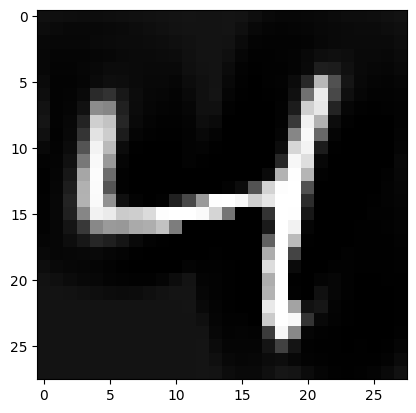

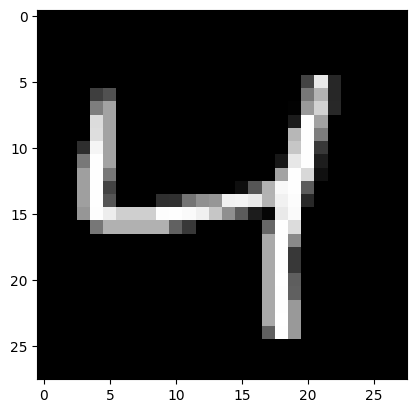

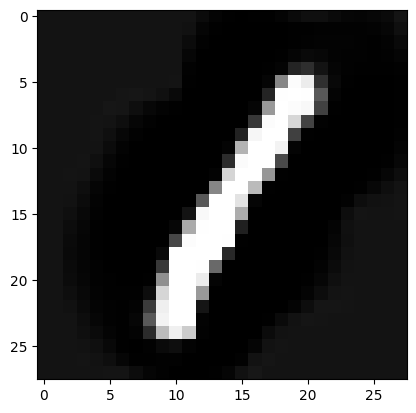

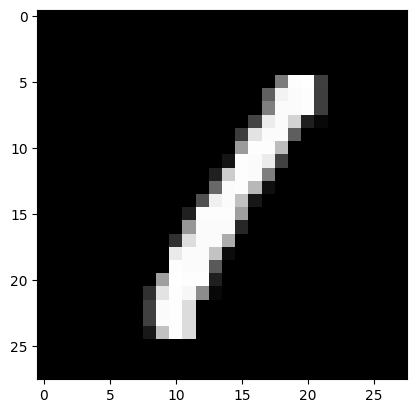

In [25]:
plt.imshow(ims[0], cmap='gray', vmin=0, vmax=1)
plt.show()
plt.imshow(images[0], cmap='gray', vmin=0, vmax=1)
plt.show()
plt.imshow(ims[1], cmap='gray', vmin=0, vmax=1)
plt.show()
plt.imshow(images[1], cmap='gray', vmin=0, vmax=1)
plt.show()